In [1]:
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

# import pmdarima as pm
# from pmdarima.arima import auto_arima

import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, adfuller, grangercausalitytests
import statsmodels.tsa.vector_ar.vecm as vecm
from statsmodels.tsa.api import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess


from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.decomposition import PCA

from prophet import Prophet
from prophet.diagnostics import cross_validation

from pylab import rcParams
import warnings
rcParams['figure.figsize'] = 18, 8
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
dataset = pd.read_csv('HomeC.csv')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
dataset.head()

,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,1451624400,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
1,1451624401,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
2,1451624402,0.931817,0.003467,0.931817,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
3,1451624403,1.022050,0.003483,1.022050,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
4,1451624404,1.139400,0.003467,1.139400,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0


In [4]:
dataset.columns

Index(['time', 'use [kW]', 'gen [kW]', 'House overall [kW]', 'Dishwasher [kW]',
       'Furnace 1 [kW]', 'Furnace 2 [kW]', 'Home office [kW]', 'Fridge [kW]',
       'Wine cellar [kW]', 'Garage door [kW]', 'Kitchen 12 [kW]',
       'Kitchen 14 [kW]', 'Kitchen 38 [kW]', 'Barn [kW]', 'Well [kW]',
       'Microwave [kW]', 'Living room [kW]', 'Solar [kW]', 'temperature',
       'icon', 'humidity', 'visibility', 'summary', 'apparentTemperature',
       'pressure', 'windSpeed', 'cloudCover', 'windBearing', 'precipIntensity',
       'dewPoint', 'precipProbability'],
      dtype='object')

In [5]:
dataset.describe()

,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],...,temperature,humidity,visibility,apparentTemperature,pressure,windSpeed,windBearing,precipIntensity,dewPoint,precipProbability
count,2.821000e+04,28210.000000,28210.000000,28210.000000,28210.000000,28210.000000,28210.000000,28210.000000,28210.000000,28210.000000,...,28209.000000,28209.000000,28209.000000,28209.000000,28209.000000,28209.000000,28209.000000,28209.000000,28209.000000,28209.000000
mean,1.451639e+09,1.089841,0.053761,1.089841,0.038649,0.230719,0.240532,0.102991,0.056587,0.018658,...,27.440563,0.631333,9.435667,20.525014,1015.070145,7.701586,216.034882,0.001824,16.020499,0.032013
std,8.143670e+03,0.692062,0.111224,0.692062,0.212196,0.222305,0.252227,0.116664,0.071992,0.034553,...,9.509686,0.146387,1.252308,12.109849,9.697009,4.622829,105.957920,0.010127,11.656667,0.134675
min,1.451624e+09,0.000300,0.000000,0.000300,0.000000,0.002433,0.002017,0.002467,0.000133,0.000217,...,4.910000,0.220000,1.920000,-8.540000,990.900000,0.220000,0.000000,0.000000,-5.380000,0.000000
25%,1.451631e+09,0.608929,0.003067,0.608929,0.000017,0.021517,0.064533,0.042250,0.005000,0.006800,...,20.870000,0.530000,9.550000,10.460000,1009.320000,4.380000,159.000000,0.000000,7.080000,0.000000
50%,1.451639e+09,0.964192,0.003350,0.964192,0.000067,0.100783,0.071267,0.050150,0.005350,0.007100,...,28.320000,0.620000,10.000000,21.230000,1014.090000,6.530000,258.000000,0.000000,14.010000,0.000000
75%,1.451646e+09,1.441829,0.030579,1.441829,0.000233,0.479533,0.566963,0.110379,0.121346,0.007400,...,34.880000,0.750000,10.000000,29.720000,1022.140000,10.270000,293.000000,0.000000,23.940000,0.000000
max,1.451653e+09,7.378917,0.554950,7.378917,1.378650,1.915517,0.775417,0.913317,0.851267,0.229633,...,55.880000,0.920000,10.000000,55.880000,1036.620000,22.810000,359.000000,0.129800,53.470000,0.810000


In [6]:
dataset.isnull().sum()

time                   0
use [kW]               0
gen [kW]               0
House overall [kW]     0
Dishwasher [kW]        0
Furnace 1 [kW]         0
Furnace 2 [kW]         0
Home office [kW]       0
Fridge [kW]            0
Wine cellar [kW]       0
Garage door [kW]       0
Kitchen 12 [kW]        0
Kitchen 14 [kW]        0
Kitchen 38 [kW]        0
Barn [kW]              0
Well [kW]              0
Microwave [kW]         0
Living room [kW]       0
Solar [kW]             1
temperature            1
icon                   1
humidity               1
visibility             1
summary                1
apparentTemperature    1
pressure               1
windSpeed              1
cloudCover             1
windBearing            1
precipIntensity        1
dewPoint               1
precipProbability      1
dtype: int64

In [7]:
dataset.describe(include='all')

,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
count,2.821000e+04,28210.000000,28210.000000,28210.000000,28210.000000,28210.000000,28210.000000,28210.000000,28210.000000,28210.000000,...,28209.000000,28209,28209.000000,28209.000000,28209.000000,28209,28209.000000,28209.000000,28209.000000,28209.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,10,NaN,NaN,NaN,80,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Clear,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,21307,NaN,NaN,NaN,4640,NaN,NaN,NaN,NaN
mean,1.451639e+09,1.089841,0.053761,1.089841,0.038649,0.230719,0.240532,0.102991,0.056587,0.018658,...,9.435667,NaN,20.525014,1015.070145,7.701586,NaN,216.034882,0.001824,16.020499,0.032013
std,8.143670e+03,0.692062,0.111224,0.692062,0.212196,0.222305,0.252227,0.116664,0.071992,0.034553,...,1.252308,NaN,12.109849,9.697009,4.622829,NaN,105.957920,0.010127,11.656667,0.134675
min,1.451624e+09,0.000300,0.000000,0.000300,0.000000,0.002433,0.002017,0.002467,0.000133,0.000217,...,1.920000,NaN,-8.540000,990.900000,0.220000,NaN,0.000000,0.000000,-5.380000,0.000000
25%,1.451631e+09,0.608929,0.003067,0.608929,0.000017,0.021517,0.064533,0.042250,0.005000,0.006800,...,9.550000,NaN,10.460000,1009.320000,4.380000,NaN,159.000000,0.000000,7.080000,0.000000
50%,1.451639e+09,0.964192,0.003350,0.964192,0.000067,0.100783,0.071267,0.050150,0.005350,0.007100,...,10.000000,NaN,21.230000,1014.090000,6.530000,NaN,258.000000,0.000000,14.010000,0.000000
75%,1.451646e+09,1.441829,0.030579,1.441829,0.000233,0.479533,0.566963,0.110379,0.121346,0.007400,...,10.000000,NaN,29.720000,1022.140000,10.270000,NaN,293.000000,0.000000,23.940000,0.000000


In [8]:
dataset.isna().sum()

time                   0
use [kW]               0
gen [kW]               0
House overall [kW]     0
Dishwasher [kW]        0
Furnace 1 [kW]         0
Furnace 2 [kW]         0
Home office [kW]       0
Fridge [kW]            0
Wine cellar [kW]       0
Garage door [kW]       0
Kitchen 12 [kW]        0
Kitchen 14 [kW]        0
Kitchen 38 [kW]        0
Barn [kW]              0
Well [kW]              0
Microwave [kW]         0
Living room [kW]       0
Solar [kW]             1
temperature            1
icon                   1
humidity               1
visibility             1
summary                1
apparentTemperature    1
pressure               1
windSpeed              1
cloudCover             1
windBearing            1
precipIntensity        1
dewPoint               1
precipProbability      1
dtype: int64

In [9]:
for col in dataset:
  dataset.nunique()
col

'precipProbability'

In [10]:
dataset.shape

(28210, 32)

In [11]:
# Check if there are entries with null values
display(dataset.info())
dataset[dataset.isnull().any(axis=1)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28210 entries, 0 to 28209
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   time                 28210 non-null  int64  
 1   use [kW]             28210 non-null  float64
 2   gen [kW]             28210 non-null  float64
 3   House overall [kW]   28210 non-null  float64
 4   Dishwasher [kW]      28210 non-null  float64
 5   Furnace 1 [kW]       28210 non-null  float64
 6   Furnace 2 [kW]       28210 non-null  float64
 7   Home office [kW]     28210 non-null  float64
 8   Fridge [kW]          28210 non-null  float64
 9   Wine cellar [kW]     28210 non-null  float64
 10  Garage door [kW]     28210 non-null  float64
 11  Kitchen 12 [kW]      28210 non-null  float64
 12  Kitchen 14 [kW]      28210 non-null  float64
 13  Kitchen 38 [kW]      28210 non-null  float64
 14  Barn [kW]            28210 non-null  float64
 15  Well [kW]            28210 non-null 

None

,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
28209,1451652609,0.541367,0.366083,0.541367,0.00025,0.496783,0.067583,0.039333,0.124567,0.0073,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Drop the line with missing values
dataset.dropna(inplace=True)

In [13]:
dataset.head()

,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,1451624400,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
1,1451624401,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
2,1451624402,0.931817,0.003467,0.931817,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
3,1451624403,1.022050,0.003483,1.022050,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
4,1451624404,1.139400,0.003467,1.139400,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0


In [14]:
# Check if there are entries with null values
display(dataset.info())
dataset[dataset.isnull().any(axis=1)]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28209 entries, 0 to 28208
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   time                 28209 non-null  int64  
 1   use [kW]             28209 non-null  float64
 2   gen [kW]             28209 non-null  float64
 3   House overall [kW]   28209 non-null  float64
 4   Dishwasher [kW]      28209 non-null  float64
 5   Furnace 1 [kW]       28209 non-null  float64
 6   Furnace 2 [kW]       28209 non-null  float64
 7   Home office [kW]     28209 non-null  float64
 8   Fridge [kW]          28209 non-null  float64
 9   Wine cellar [kW]     28209 non-null  float64
 10  Garage door [kW]     28209 non-null  float64
 11  Kitchen 12 [kW]      28209 non-null  float64
 12  Kitchen 14 [kW]      28209 non-null  float64
 13  Kitchen 38 [kW]      28209 non-null  float64
 14  Barn [kW]            28209 non-null  float64
 15  Well [kW]            28209 non-null 

None

,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability


In [15]:
obj_cols = ['icon', 'summary', 'cloudCover']
for i in obj_cols:
    print(f'{i} takes the following unique values {dataset[i].unique()}')

icon takes the following unique values ['clear-night' 'partly-cloudy-night' 'clear-day' 'cloudy'
 'partly-cloudy-day' 'rain' 'snow' 'wind']
summary takes the following unique values ['Clear' 'Mostly Cloudy' 'Overcast' 'Partly Cloudy' 'Drizzle' 'Light Rain'
 'Rain' 'Light Snow' 'Flurries' 'Breezy']
cloudCover takes the following unique values ['cloudCover' '0.75' '0' '1' '0.31' '0.44' '0.13' '0.19' '0.25' '0.16'
 '0.21' '0.15' '0.14' '0.27' '0.28' '0.17' '0.05' '0.1' '0.26' '0.29'
 '0.11' '0.09' '0.12' '0.06' '0.02' '0.08' '0.04' '0.35' '0.22' '0.23'
 '0.54' '0.39' '0.03' '0.07' '0.76' '0.62' '0.18' '0.79' '0.48' '0.24'
 '0.57' 0.24 1.0 0.31 0.28 0.15 0.41 0.1 0.12 0.08 0.09 0.19 0.04 0.05
 0.29 0.27 0.35 0.18 0.06 0.03 0.11 0.14 0.25 0.78 0.0 0.16 0.21 0.23 0.17
 0.75 0.26 0.2 0.76 0.13 0.77 0.46 0.07 0.55 0.02 0.01]


In [16]:
dataset[dataset['cloudCover']=='cloudCover'].index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57],
           dtype='int64')

In [17]:
dataset['cloudCover'].replace('cloudCover', np.nan, inplace=True)
dataset['cloudCover'].fillna(method='bfill', inplace=True)
dataset['cloudCover'] = dataset['cloudCover'].astype('float')

In [18]:
dataset.columns = [col.replace(' [kW]', '') for col in dataset.columns]
dataset.columns

Index(['time', 'use', 'gen', 'House overall', 'Dishwasher', 'Furnace 1',
       'Furnace 2', 'Home office', 'Fridge', 'Wine cellar', 'Garage door',
       'Kitchen 12', 'Kitchen 14', 'Kitchen 38', 'Barn', 'Well', 'Microwave',
       'Living room', 'Solar', 'temperature', 'icon', 'humidity', 'visibility',
       'summary', 'apparentTemperature', 'pressure', 'windSpeed', 'cloudCover',
       'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability'],
      dtype='object')

In [19]:
dataset['sum_Furnace'] = dataset[['Furnace 1','Furnace 2']].sum(axis=1)
dataset['avg_Kitchen'] = dataset[['Kitchen 12','Kitchen 14','Kitchen 38']].mean(axis=1)

In [20]:
dataset = dataset.drop(['Kitchen 12','Kitchen 14','Kitchen 38'], axis=1)
dataset = dataset.drop(['Furnace 1','Furnace 2'], axis=1)
dataset.columns

Index(['time', 'use', 'gen', 'House overall', 'Dishwasher', 'Home office',
       'Fridge', 'Wine cellar', 'Garage door', 'Barn', 'Well', 'Microwave',
       'Living room', 'Solar', 'temperature', 'icon', 'humidity', 'visibility',
       'summary', 'apparentTemperature', 'pressure', 'windSpeed', 'cloudCover',
       'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability',
       'sum_Furnace', 'avg_Kitchen'],
      dtype='object')

In [21]:
dataset['time'].head()

0    1451624400
1    1451624401
2    1451624402
3    1451624403
4    1451624404
Name: time, dtype: int64

In [22]:
import time 
print(' start ' , time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(int(dataset['time'].iloc[0]))))

 start  2016-01-01 05:00:00


In [23]:
time_index = pd.date_range('2016-01-01 05:00', periods=len(dataset),  freq='min')  
time_index = pd.DatetimeIndex(time_index)
dataset = dataset.set_index(time_index)
dataset = dataset.drop(['time'], axis=1)
dataset.iloc[np.r_[0:5,-5:0]].iloc[:,0]

2016-01-01 05:00:00    0.932833
2016-01-01 05:01:00    0.934333
2016-01-01 05:02:00    0.931817
2016-01-01 05:03:00    1.022050
2016-01-01 05:04:00    1.139400
2016-01-20 19:04:00    0.197683
2016-01-20 19:05:00    0.167400
2016-01-20 19:06:00    0.193483
2016-01-20 19:07:00    0.387633
2016-01-20 19:08:00    0.559133
Name: use, dtype: float64

In [24]:
dataset.shape

(28209, 28)

<AxesSubplot:>

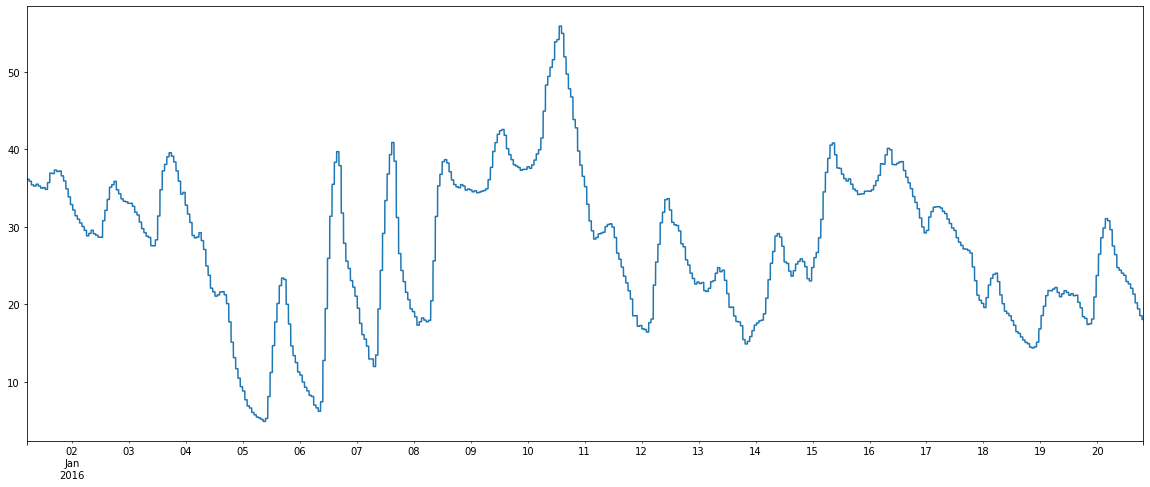

In [25]:
dataset['temperature'].plot(figsize=(20,8))

<AxesSubplot:>

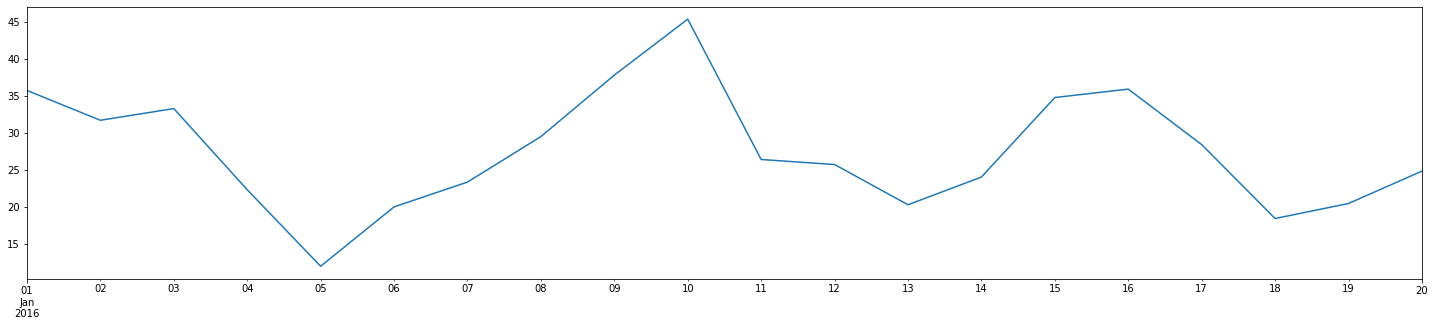

In [26]:
dataset['temperature'].resample(rule='D').mean().plot(figsize=(25,5))

In [27]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (25,5)

<AxesSubplot:>

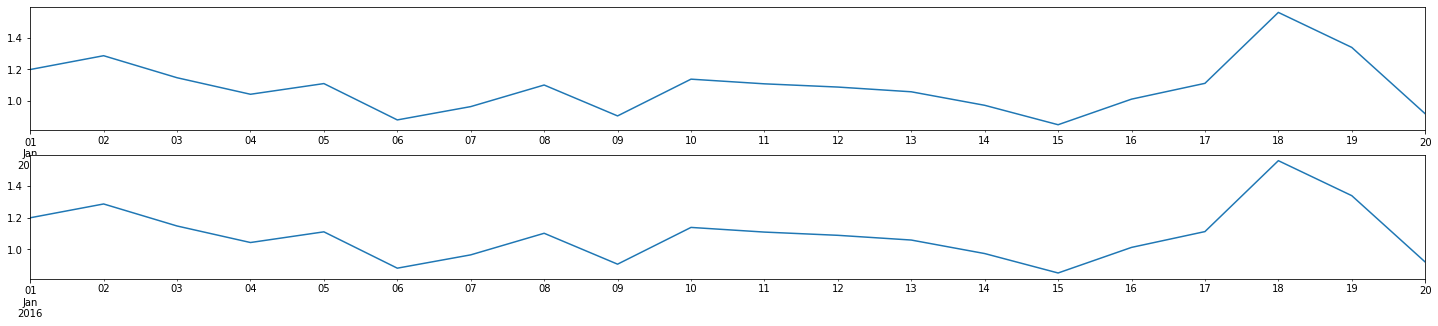

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=1)
dataset['use'].resample('D').mean().plot(ax=axes[0])
dataset['House overall'].resample('D').mean().plot(ax=axes[1])

In [29]:
# dataset = dataset.drop(columns=['House overall'])
# dataset.shape

In [30]:
dataset['icon'].value_counts()

clear-night            13187
clear-day               8120
partly-cloudy-night     3364
partly-cloudy-day       1276
rain                    1276
snow                     464
cloudy                   406
wind                     116
Name: icon, dtype: int64

In [31]:
dataset = dataset.drop(columns=['summary', 'icon'])
dataset.shape

(28209, 26)

In [32]:
dataset['cloudCover'].unique()

array([0.75, 0.  , 1.  , 0.31, 0.44, 0.13, 0.19, 0.25, 0.16, 0.21, 0.15,
       0.14, 0.27, 0.28, 0.17, 0.05, 0.1 , 0.26, 0.29, 0.11, 0.09, 0.12,
       0.06, 0.02, 0.08, 0.04, 0.35, 0.22, 0.23, 0.54, 0.39, 0.03, 0.07,
       0.76, 0.62, 0.18, 0.79, 0.48, 0.24, 0.57, 0.41, 0.78, 0.2 , 0.77,
       0.46, 0.55, 0.01])

In [33]:
dataset['cloudCover'][56:60]

2016-01-01 05:56:00    0.75
2016-01-01 05:57:00    0.75
2016-01-01 05:58:00    0.75
2016-01-01 05:59:00    0.75
Freq: T, Name: cloudCover, dtype: float64

In [34]:
dataset[dataset['cloudCover']=='cloudCover'].shape

(0, 26)

In [35]:
dataset['cloudCover'].replace(['cloudCover'], method='bfill', inplace=True)
dataset['cloudCover'] = dataset['cloudCover'].astype('float')
dataset['cloudCover'].unique()

array([0.75, 0.  , 1.  , 0.31, 0.44, 0.13, 0.19, 0.25, 0.16, 0.21, 0.15,
       0.14, 0.27, 0.28, 0.17, 0.05, 0.1 , 0.26, 0.29, 0.11, 0.09, 0.12,
       0.06, 0.02, 0.08, 0.04, 0.35, 0.22, 0.23, 0.54, 0.39, 0.03, 0.07,
       0.76, 0.62, 0.18, 0.79, 0.48, 0.24, 0.57, 0.41, 0.78, 0.2 , 0.77,
       0.46, 0.55, 0.01])

In [36]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28209 entries, 2016-01-01 05:00:00 to 2016-01-20 19:08:00
Freq: T
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   use                  28209 non-null  float64
 1   gen                  28209 non-null  float64
 2   House overall        28209 non-null  float64
 3   Dishwasher           28209 non-null  float64
 4   Home office          28209 non-null  float64
 5   Fridge               28209 non-null  float64
 6   Wine cellar          28209 non-null  float64
 7   Garage door          28209 non-null  float64
 8   Barn                 28209 non-null  float64
 9   Well                 28209 non-null  float64
 10  Microwave            28209 non-null  float64
 11  Living room          28209 non-null  float64
 12  Solar                28209 non-null  float64
 13  temperature          28209 non-null  float64
 14  humidity             28209 non-null  float6

<AxesSubplot:>

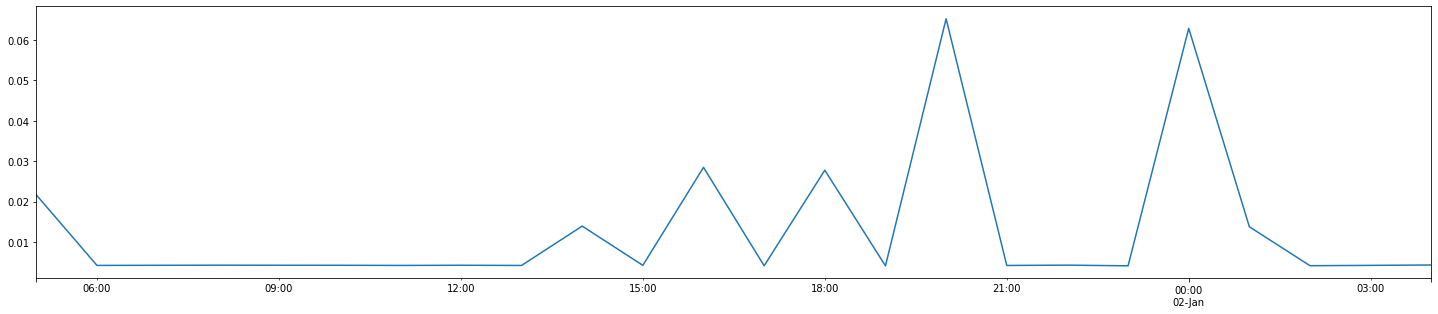

In [37]:
dataset['Microwave'].resample("h").mean().iloc[:24].plot()

[Text(0.5, 0, 'Daily Hours'), Text(0, 0.5, 'Microwave Usage (kW)')]

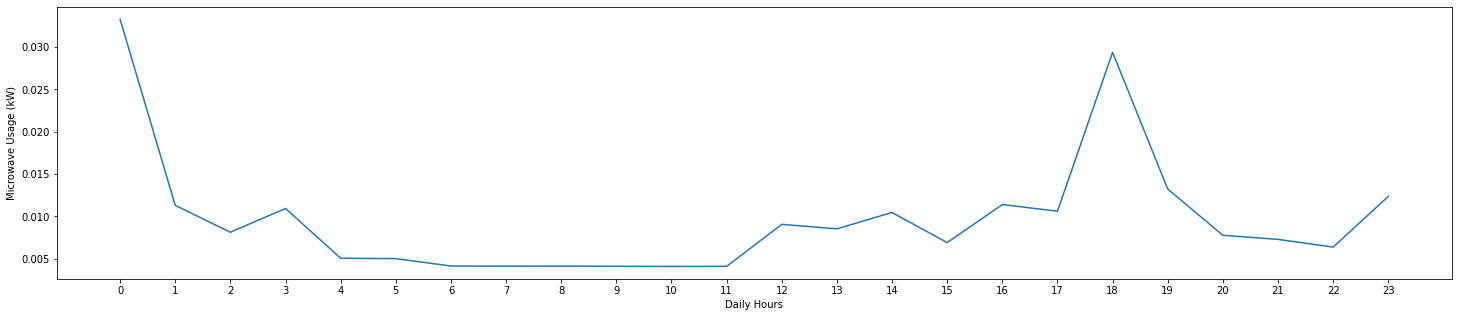

In [38]:
dataset.groupby(dataset.index.hour).mean()['Microwave'].plot(xticks=np.arange(24)).set(xlabel='Daily Hours', ylabel='Microwave Usage (kW)')

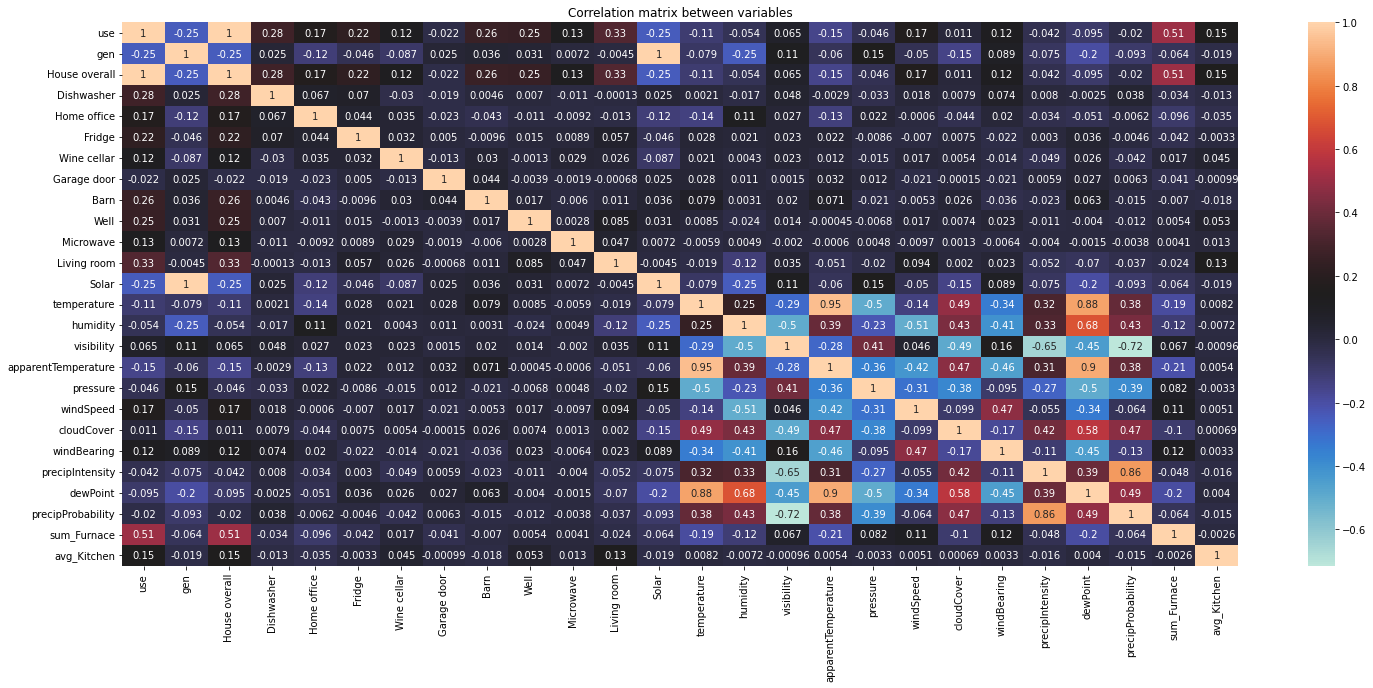

In [39]:
plt.figure(figsize=(25,10))
sns.heatmap(dataset.corr(), annot=True, cmap='icefire').set_title('Correlation plot')
plt.title('Correlation matrix between variables')
plt.show()

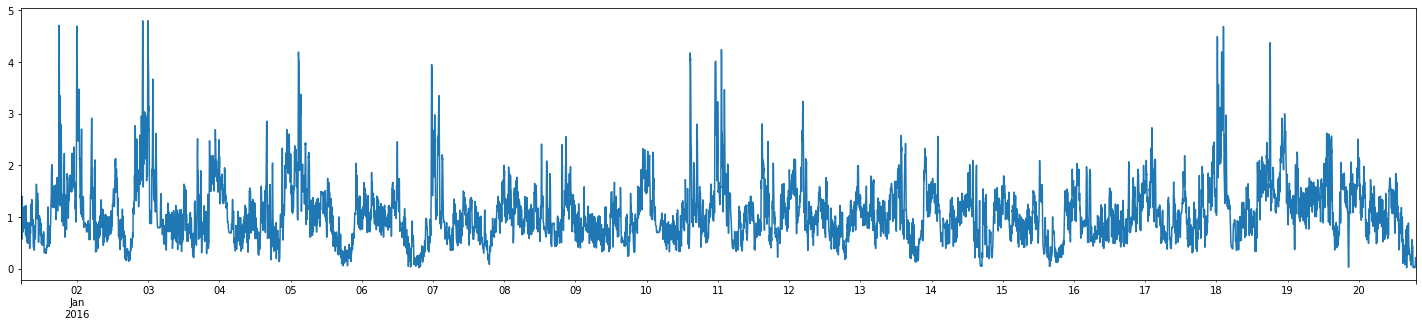

In [40]:
# Simple Moving Average
dataset['use'] = dataset['use'].rolling(10).mean().plot()

(None, None)

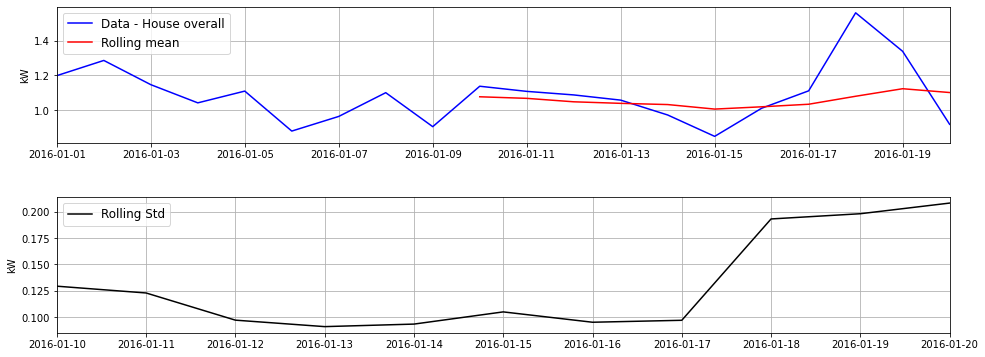

In [41]:
data_daily = dataset['House overall'].resample('d').mean()
rollingMEAN = data_daily.rolling(window=10).mean()
rollingSTD = data_daily.rolling(window=10).std()
#Plot
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,6))
plt.subplots_adjust(hspace=0.4)
ax1.plot(data_daily, c='blue',label='Data - House overall')
ax1.plot(rollingMEAN, c='red', label='Rolling mean')
ax2.plot(rollingSTD, c='black',label = 'Rolling Std')

ax1.legend(fontsize=12), ax2.legend(fontsize=12)
ax1.set_ylabel('kW'), ax2.set_ylabel('kW')
ax1.margins(x=0), ax2.margins(x=0)
ax1.grid(), ax2.grid()

In [42]:
from statsmodels.tsa.stattools import adfuller

resultDFtest = adfuller(data_daily, autolag='AIC')
Out = pd.Series(resultDFtest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key1, value1 in resultDFtest[4].items():
    Out['Critical Value (%s)'%key1] = value1
    
print('DICK-FULLER RESULTS: \n\n{}'.format(Out))

DICK-FULLER RESULTS: 

Test Statistic                -1.027768e+01
p-value                        3.852236e-18
#Lags Used                     8.000000e+00
Number of Observations Used    1.100000e+01
Critical Value (1%)           -4.223238e+00
Critical Value (5%)           -3.189369e+00
Critical Value (10%)          -2.729839e+00
dtype: float64


In [43]:
size = int(len(data_daily)*0.7)
train = data_daily[:size]
test = data_daily[size:]
print('Number of points in series:', len(data_daily))
print('Number of points in train:', len(train))
print('Number of points in test:', len(test))

Number of points in series: 20
Number of points in train: 14
Number of points in test: 6


In [44]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train, order=(2,1,1))
#model = sm.tsa.statespace.SARIMAX(train, order=(2,1,1), seasonal_order=(5,0,1,12))
model_fit = model.fit()
print('Akaike information criterion: ', model_fit.aic)

Akaike information criterion:  -14.916521501483167


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:          House overall   No. Observations:                   14
Model:                 ARIMA(2, 1, 1)   Log Likelihood                  11.458
Date:                Mon, 06 Mar 2023   AIC                            -14.917
Time:                        05:30:27   BIC                            -12.657
Sample:                    01-01-2016   HQIC                           -15.381
                         - 01-14-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2380      0.411     -3.010      0.003      -2.044      -0.432
ar.L2         -0.6342      0.241     -2.633      0.008      -1.106      -0.162
ma.L1          0.8234      0.806      1.022      0.3

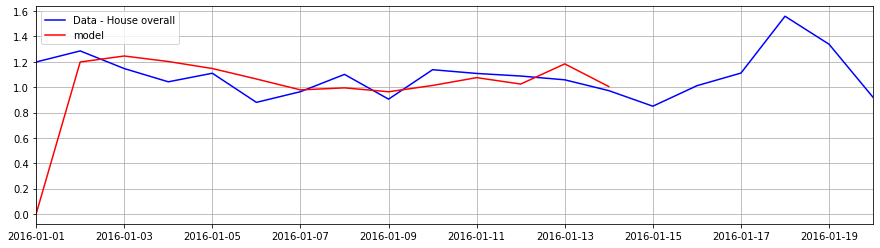

In [45]:
plt.figure(figsize=(15,4))
plt.plot(data_daily, c='blue',label='Data - House overall')
plt.plot(model_fit.predict(dynamic=False), c='red', label='model')
plt.legend()
plt.grid(), plt.margins(x=0);
print(model_fit.summary())

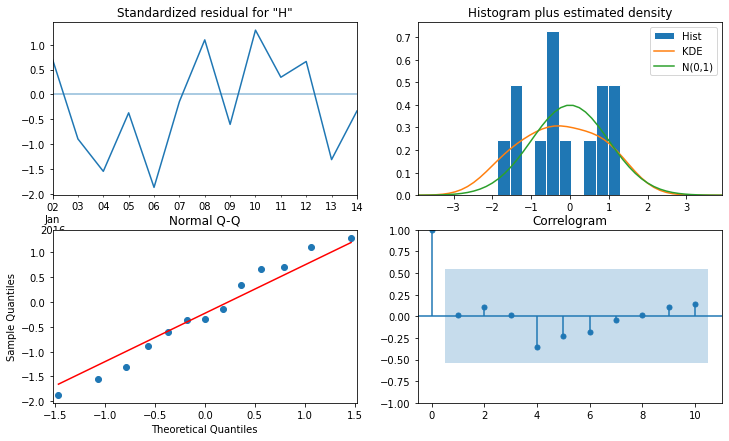

In [46]:
# Residuals

model_fit.plot_diagnostics(figsize=(12,7))
plt.show()

MSE: 0.075
RMSE: 0.274
MAE: 0.214
MAPE: 0.176
MASE: 1.932
R^2 score: -0.230


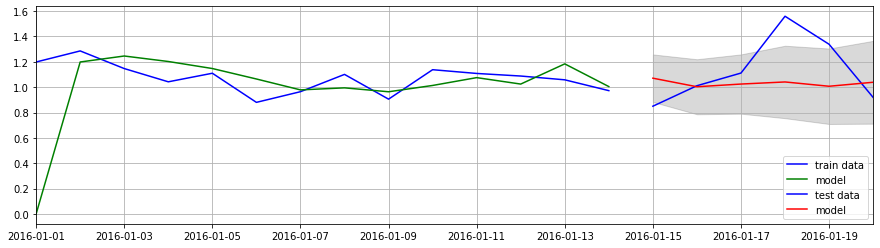

In [47]:
# from sklearn.metrics import mean_absolute_error,r2_score

# new_fit = model_fit.append(data_daily[size:size+1], refit=False)
# forecast = model_fit.forecast(len(test))
# confidence = model_fit.get_forecast(len(test)).conf_int(0.05)
# #forecast = model_fit.predict(246, 351)
# plt.figure(figsize=(15,4))
# plt.plot(train, c='blue',label='train data')
# plt.plot(model_fit.predict(dynamic=False), c='green', label='model')
# plt.plot(test, c='blue',label='test data')
# plt.plot(forecast, c='red', label='model')
# plt.fill_between(confidence.index,confidence['lower House overall'],
#                  confidence['upper House overall'], color='k', alpha=.15)
# plt.legend()
# plt.grid(), plt.margins(x=0);
# # calcolo errore
# print('MSE: %.3f' % (mean_squared_error(test, forecast)))
# print('RMSE: %.3f' % np.sqrt(mean_squared_error(test, forecast)))
# MAE = mean_absolute_error(test, forecast)
# MAPE = np.mean(np.abs(forecast - test)/np.abs(test))
# MASE = np.mean(np.abs(test - forecast))/(np.abs(np.diff(train)).sum()/(len(train)-1))
# print('MAE: %.3f' % MAE)
# print('MAPE: %.3f' %MAPE)
# print('MASE: %.3f' %MASE)
# print('R^2 score: %.3f' % r2_score(test, forecast))

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

forecast = model_fit.forecast(len(test))
confidence = model_fit.get_forecast(len(test)).conf_int(0.05)
lower_bound = confidence.iloc[:, 0]
upper_bound = confidence.iloc[:, 1]

plt.figure(figsize=(15,4))
plt.plot(train, c='blue',label='train data')
plt.plot(model_fit.predict(dynamic=False), c='green', label='model')
plt.plot(test, c='blue',label='test data')
plt.plot(forecast, c='red', label='model')
plt.fill_between(test.index, lower_bound, upper_bound, color='k', alpha=.15)
plt.legend()
plt.grid()
plt.margins(x=0)

# calcolo errore
print('MSE: %.3f' % (mean_squared_error(test, forecast)))
print('RMSE: %.3f' % np.sqrt(mean_squared_error(test, forecast)))
MAE = mean_absolute_error(test, forecast)
MAPE = np.mean(np.abs(forecast - test)/np.abs(test))
MASE = np.mean(np.abs(test - forecast))/(np.abs(np.diff(train)).sum()/(len(train)-1))
print('MAE: %.3f' % MAE)
print('MAPE: %.3f' %MAPE)
print('MASE: %.3f' %MASE)
print('R^2 score: %.3f' % r2_score(test, forecast))


In [48]:
import joblib

# Save the trained model as a pickle file
joblib.dump(model, 'model.pkl')

['model.pkl']

In [49]:
# import pickle
# import numpy as np
# import statsmodels.api as sm
# import joblib

# # Load the trained model from the `model.pkl` file
# joblib.load('model.pkl')

# # Determine the length of time series you want to create
# num_time_steps = 1000

# # Generate a set of random inputs
# random_inputs = np.random.normal(loc=0, scale=1, size=num_time_steps)

# # Use the trained ARIMA model to generate synthetic time series
# synthetic_time_series = model.predict(random_inputs)

# # Combine the random inputs and synthetic time series to create a synthetic time series dataset
# synthetic_data = np.column_stack((random_inputs, synthetic_time_series))


In [50]:
# import numpy as np
# import pmdarima as pm
# import joblib
# import matplotlib.pyplot as plt

# # Load the dumped ARIMA model
# arima_model = joblib.load("arima_model.pkl")

# # Generate synthetic data using the dumped ARIMA model
# data = arima_model.generate_sample(n_samples=1000)

# # Plot the time series data
# plt.plot(data)
# plt.title("Synthetic Time Series Data")
# plt.show()


In [51]:
# import numpy as np
# import pandas as pd
# import statsmodels.api as sm

# # Choose the column to generate synthetic data
# data = dataset['Fridge'].values

# # Set the ARIMA model parameters
# p = 0
# d = 1
# q = 0

# # Generate synthetic data using the ARIMA model
# np.random.seed(123)
# arima = sm.tsa.ARIMA(data, order=(p, d, q))
# arima_fit = arima.fit()
# synthetic_data = arima_fit.simulate(nsimulations=20000)

# # Save the synthetic data to a CSV file
# pd.DataFrame(synthetic_data).to_csv('synthetic_data.csv', index=False)

In [52]:
# import numpy as np
# import pandas as pd
# import statsmodels.api as sm


# # Choose the columns to generate synthetic data
# columns = ['gen', 'House overall', 'Dishwasher']

# # Set the ARIMA model parameters
# p = 0
# d = 1
# q = 0

# # Generate synthetic data using the ARIMA model
# synthetic_data = np.empty((len(dataset), len(columns)))
# for i, column in enumerate(columns):
#     data = dataset[column].values
#     arima = sm.tsa.ARIMA(data, order=(p, d, q))
#     arima_fit = arima.fit()
#     synthetic_data[:, i] = arima_fit.simulate(nsimulations=len(dataset))

# # Save the synthetic data to a CSV file
# pd.DataFrame(synthetic_data, columns=columns).to_csv('synthetic.csv', index=False)


In [53]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 17.5 MB/s eta 0:00:00


In [54]:
# import numpy as np
# import pandas as pd
# import pmdarima as pm


# # Choose the columns to generate synthetic data
# columns = ['gen', 'House overall', 'Dishwasher']

# # Generate synthetic data using the ARIMA model with optimal parameters
# np.random.seed(123)
# synthetic_data = np.empty((len(dataset), len(columns)))
# for i, column in enumerate(columns):
#     data = dataset[column].values
#     arima = pm.auto_arima(data, seasonal=False, stepwise=True, suppress_warnings=True)
#     synthetic_data[:, i] = arima.predict(n_periods=len(dataset))

# # Save the synthetic data to a CSV file
# pd.DataFrame(synthetic_data, columns=columns).to_csv('synthetic_data.csv', index=False)

In [55]:
# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import MinMaxScaler
# import statsmodels.api as sm


# # Choose the columns to generate synthetic data
# columns = ['gen', 'House overall', 'Dishwasher']

# # Set the ARIMA model parameters
# p = 0
# d = 1
# q = 0

# # Generate synthetic data using the ARIMA model
# synthetic_data = np.empty((len(dataset), len(columns)))
# for i, column in enumerate(columns):
#     data = dataset[column].values
#     arima = sm.tsa.ARIMA(data, order=(p, d, q))
#     arima_fit = arima.fit()
#     synthetic_data[:, i] = arima_fit.simulate(nsimulations=len(dataset))

# # Normalize the synthetic data
# scaler = MinMaxScaler()
# synthetic_data_norm = scaler.fit_transform(synthetic_data)

# # Save the normalized synthetic data to a CSV file
# pd.DataFrame(synthetic_data_norm, columns=columns).to_csv('synthetic_norm.csv', index=False)


In [56]:
# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import MinMaxScaler
# import pmdarima as pm


# # Choose the columns to generate synthetic data
# columns = ['gen', 'House overall', 'Dishwasher']

# # Generate synthetic data using auto ARIMA
# synthetic_data = np.empty((len(dataset), len(columns)))
# for i, column in enumerate(columns):
#     data = dataset[column].values
#     arima_model = pm.auto_arima(data, suppress_warnings=True)
#     synthetic_data[:, i] = arima_model.predict(n_periods=len(dataset))

# # Normalize the synthetic data
# scaler = MinMaxScaler()
# synthetic_data_norm = scaler.fit_transform(synthetic_data)

# # Save the normalized synthetic data to a CSV file
# pd.DataFrame(synthetic_data_norm, columns=columns).to_csv('synthetic_norm_auto.csv', index=False)


In [57]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import MinMaxScaler
# from copulas.multivariate import GaussianMultivariate

# # Load real data
# data = pd.read_csv('HomeC.csv')

# # Extract variables of interest
# X = data[['electricity', 'water']].values

# # Scale variables between 0 and 1
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)

# # Fit Gaussian copula model
# copula = GaussianMultivariate()
# copula.fit(X_scaled)

# # Generate synthetic data
# n_samples = len(X)
# synthetic_data = copula.sample(n_samples)

# # Inverse transform the synthetic data to original scale
# synthetic_data = scaler.inverse_transform(synthetic_data)

# # Plot comparison of real and synthetic data
# plt.plot(X[:, 0], label='Real electricity')
# plt.plot(synthetic_data[:, 0], label='Synthetic electricity')
# plt.plot(X[:, 1], label='Real water')
# plt.plot(synthetic_data[:, 1], label='Synthetic water')
# plt.legend()
# plt.show()


In [58]:
!pip install copulas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 KB 3.5 MB/s eta 0:00:00


In [59]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import MinMaxScaler
# !pip install copulas
# from copulas.multivariate import GaussianMultivariate

# # # Upload data file
# # from google.colab import files
# # uploaded = files.upload()

# # # Load real data
# # data = pd.read_csv('smart_meter_data.csv')

# # Extract variables of interest
# X = dataset[['Dishwasher', 'House overall']].values

# # Scale variables between 0 and 1
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)

# # Fit Gaussian copula model
# copula = GaussianMultivariate()
# copula.fit(X_scaled)

# # Generate synthetic data
# n_samples = len(X)
# synthetic_data = copula.sample(n_samples)

# # Inverse transform the synthetic data to original scale
# synthetic_data = scaler.inverse_transform(synthetic_data)

# # Plot comparison of real and synthetic data
# plt.plot(X[:, 0], label='Dishwasher')
# plt.plot(synthetic_data[:, 0], label='Synthetic Dishwasher')
# plt.plot(X[:, 1], label='House overall')
# plt.plot(synthetic_data[:, 1], label='Synthetic House overall')
# plt.legend()
# plt.show()


In [60]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import MinMaxScaler
# from copulas.multivariate import GaussianMultivariate

# # # Load real data
# # data = pd.read_csv('smart_meter_data.csv')

# # Extract washing machine power consumption
# X = dataset[['Dishwasher']].values

# # Scale variables between 0 and 1
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)

# # Fit Gaussian copula model
# copula = GaussianMultivariate()
# copula.fit(X_scaled)

# # Generate synthetic data
# n_samples = len(X)
# synthetic_data = copula.sample(n_samples)

# # Inverse transform the synthetic data to original scale
# synthetic_data = scaler.inverse_transform(synthetic_data)

# # Plot comparison of real and synthetic data
# plt.plot(X, label='Real')
# plt.plot(synthetic_data, label='Synthetic')
# plt.legend()
# plt.show()


In [62]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Load datasets
# dataset1 = pd.read_csv('synthetic_norm.csv')
# dataset2 = pd.read_csv('HomeC.csv')



In [63]:
# dataset1.columns

In [64]:
# dataset2.columns

In [65]:
# # Extract column of interest
# column_name = 'column_name'
# column1 = dataset1['gen']
# column2 = dataset2['gen [kW]']

# # # Create plots
# # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# # # Plot data for dataset1
# # ax1.plot(column1, label='Synthetic Dataset')
# # ax1.set_xlabel('X label')
# # ax1.set_ylabel('Power Consumption [kW]')
# # ax1.legend()

# # # Plot data for dataset2
# # ax2.plot(column2, label='Real Dataset')
# # ax2.set_xlabel('X label')
# # ax2.set_ylabel('Power Consumption [kW]')
# # ax2.legend()

# # # Display the plots
# # plt.show()


# # Create plot
# fig, ax = plt.subplots(figsize=(10, 5))

# # Plot data for dataset1 and dataset2
# ax.plot(column1, label='Synthetic Dataset using Auto-ARIMA model')
# ax.plot(column2, label='Real Dataset')
# ax.set_xlabel('Gen')
# ax.set_ylabel('Power Consumption [kW]')
# ax.legend()

# # Display the plot
# plt.show()


In [66]:

# # Load datasets
# dataset3 = pd.read_csv('syn_gaussian.csv')
# dataset4 = pd.read_csv('HomeC.csv')

In [67]:
# # Extract column of interest
# column_name = 'column_name'
# column1 = dataset3['gen [kW]']
# column2 = dataset4['gen [kW]']

# # # Create plots
# # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# # # Plot data for dataset1
# # ax1.plot(column1, label='Synthetic Dataset')
# # ax1.set_xlabel('X label')
# # ax1.set_ylabel('Power Consumption [kW]')
# # ax1.legend()

# # # Plot data for dataset2
# # ax2.plot(column2, label='Real Dataset')
# # ax2.set_xlabel('X label')
# # ax2.set_ylabel('Power Consumption [kW]')
# # ax2.legend()

# # # Display the plots
# # plt.show()


# # Create plot
# fig, ax = plt.subplots(figsize=(10, 5))

# # Plot data for dataset1 and dataset2
# ax.plot(column1, label='Synthetic Dataset using Gaussian Copula')
# ax.plot(column2, label='Real Dataset')
# ax.set_xlabel('Gen')
# ax.set_ylabel('Power Consumption [kW]')
# ax.legend()

# # Display the plot
# plt.show()


In [68]:
import pandas as pd
import numpy as np

# Load dataset
# df = pd.read_csv('dataset.csv')

# Loop over each column
for col in dataset.columns:
    # Get actual and predicted values
    actual = dataset['gen'].values
    predicted = np.random.normal(loc=actual.mean(), scale=actual.std(), size=len(actual))
    
    # Calculate RMSE, MAE, and MAPE
    rmse = np.sqrt(((actual - predicted) ** 2).mean())
    mae = np.abs(actual - predicted).mean()
    eps = 1e-8  # small value to avoid divide-by-zero errors
    mask = actual != 0  # mask of non-zero values
    mape = (np.abs(actual - predicted) / (actual + eps))[mask].mean() * 100
    
    # Print results
    print(f"{col} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%")


use - RMSE: 0.16, MAE: 0.12, MAPE: 2678.23%
gen - RMSE: 0.16, MAE: 0.12, MAPE: 2668.45%
House overall - RMSE: 0.16, MAE: 0.12, MAPE: 2718.88%
Dishwasher - RMSE: 0.16, MAE: 0.12, MAPE: 2646.25%
Home office - RMSE: 0.16, MAE: 0.12, MAPE: 2692.77%
Fridge - RMSE: 0.16, MAE: 0.12, MAPE: 2678.49%
Wine cellar - RMSE: 0.16, MAE: 0.12, MAPE: 2761.87%
Garage door - RMSE: 0.16, MAE: 0.12, MAPE: 2746.07%
Barn - RMSE: 0.16, MAE: 0.12, MAPE: 2782.63%
Well - RMSE: 0.16, MAE: 0.12, MAPE: 2701.50%
Microwave - RMSE: 0.16, MAE: 0.12, MAPE: 2755.44%
Living room - RMSE: 0.16, MAE: 0.12, MAPE: 2687.17%
Solar - RMSE: 0.16, MAE: 0.12, MAPE: 2707.74%
temperature - RMSE: 0.16, MAE: 0.12, MAPE: 2784.54%
humidity - RMSE: 0.16, MAE: 0.12, MAPE: 2715.87%
visibility - RMSE: 0.16, MAE: 0.12, MAPE: 2664.30%
apparentTemperature - RMSE: 0.16, MAE: 0.12, MAPE: 2664.70%
pressure - RMSE: 0.16, MAE: 0.12, MAPE: 2672.25%
windSpeed - RMSE: 0.16, MAE: 0.12, MAPE: 2731.54%
cloudCover - RMSE: 0.16, MAE: 0.12, MAPE: 2672.42%
wind

In [73]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Load data
# data = pd.read_csv('data.csv', index_col='Time', parse_dates=['Time'])

# Differencing
dataset['living_room_diff'] = dataset['Living room'].diff()
dataset['solar_diff'] = dataset['Solar'].diff()

# # Drop NaN values
# data.dropna(inplace=True)
# Replace NaN and Inf values with 0
dataset = dataset.replace([np.inf, -np.inf, np.nan], 0)

# Augmented Dickey-Fuller test
result_living_room = adfuller(dataset['living_room_diff'])
result_solar = adfuller(dataset['solar_diff'])

print('Living room:')
print(f'ADF Statistic: {result_living_room[0]}')
print(f'p-value: {result_living_room[1]}')
print(f'Critical Values: {result_living_room[4]}')
if result_living_room[0] < result_living_room[4]['5%']:
    print('Stationary')
else:
    print('Non-Stationary')

print('Solar:')
print(f'ADF Statistic: {result_solar[0]}')
print(f'p-value: {result_solar[1]}')
print(f'Critical Values: {result_solar[4]}')
if result_solar[0] < result_solar[4]['5%']:
    print('Stationary')
else:
    print('Non-Stationary')


Living room:
ADF Statistic: -27.23902093988651
p-value: 0.0
Critical Values: {'1%': -3.430582257128925, '5%': -2.861642651126369, '10%': -2.566824638104926}
Stationary
Solar:
ADF Statistic: -27.045160256679107
p-value: 0.0
Critical Values: {'1%': -3.4305822488801128, '5%': -2.8616426474807684, '10%': -2.5668246361644576}
Stationary
